## Load dependencies

In [1]:
caffe_root = '/home/haocabbage/caffe/caffe/' 
data_root = '/home/haocabbage/Desktop/imgStyle/'

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
## Use GPU    
caffe.set_device(0)
caffe.set_mode_gpu()

import numpy as np
from scipy.misc import imsave
from skimage.transform import rescale
from scipy.ndimage.interpolation import zoom
from scipy.optimize import minimize
import time

import matplotlib.pyplot as plt
%matplotlib inline

/home/haocabbage/caffe/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/haocabbage/caffe/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/haocabbage/caffe/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


## Specify parameters

In [2]:
# layer for content features
ct_layer = 'conv4_2'

# layer(s) for style features
st_layers = ['conv1_1', 
             'conv2_1',
             'conv3_1',
             'conv4_1',
             'conv5_1']

# content and style layers weights
st_wts = np.repeat(0.2, 5)

# training layers dictionary
layers_tr = {'content': None, 'style': None}
layers_tr['style'] = {st_layers[i]:st_wts[i] for i in range(len(st_layers))}
layers_tr['content'] = ct_layer

# max input image side length
length = 256.0

In [3]:
layers_tr

{'content': 'conv4_2',
 'style': {'conv1_1': 0.20000000000000001,
  'conv2_1': 0.20000000000000001,
  'conv3_1': 0.20000000000000001,
  'conv4_1': 0.20000000000000001,
  'conv5_1': 0.20000000000000001}}

## Load and rescale images

In [4]:
# import content image and style image
style = caffe.io.load_image(data_root+'style.jpg')
content = caffe.io.load_image(data_root+'content.jpg')
style = rescale(style, length/max(style.shape))
content = rescale(content, length/max(content.shape))

## Load pretrained model

In [5]:
# load pre-trained model
net = caffe.Net(caffe_root+'models/vgg19/vgg19_normalised.prototxt',
            caffe_root+'models/vgg19/vgg19_normalised.caffemodel',
            caffe.TEST)

model_mean = np.load(caffe_root+'models/vgg19/ilsvrc_2012_mean.npy')
model_mean = model_mean.mean(1).mean(1)

transformer = caffe.io.Transformer({"data": net.blobs["data"].data.shape})
transformer.set_transpose("data", (2,0,1))
transformer.set_channel_swap("data", (2,1,0))
transformer.set_raw_scale("data", 255)
transformer.set_mean("data", model_mean)

# layers for backpropagation
layers = net.blobs.keys()
layers = [layer for layer in layers if layer in st_layers+[ct_layer]]

In [6]:
layers

['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1']

## Get content layer and gram matrix for each style layers

In [7]:
# content layer
net.blobs['data'].reshape(1,3,content.shape[0],content.shape[1])
transformer.inputs['data'] = (1,3)+content.shape[:2]
net.blobs['data'].data[0] = transformer.preprocess('data', content)
net.forward()
P_ct = net.blobs[ct_layer].data[0].copy()

# style gram matrices
net.blobs['data'].reshape(1,3,style.shape[0],style.shape[1])
transformer.inputs['data'] = (1,3)+style.shape[:2]
net.blobs['data'].data[0] = transformer.preprocess('data', style)
net.forward()
G_st = {}
for l in layers_tr['style'].keys():
    temp = net.blobs[l].data[0].copy()
    dim = temp.shape
    temp = temp.reshape(dim[0], dim[1]*dim[2])
    G_st[l] = np.dot(temp, temp.T)

## Reconstruct from white noise 

In [8]:
def getObj(data):
    # get content layer and gram matrices for the image
    net.blobs['data'].data[0] = data
    net.forward()
    
    # content layer
    P = net.blobs[ct_layer].data[0].copy()
    
    # style gram matrices
    G = {}
    for l in layers_tr['style'].keys():
        temp = net.blobs[l].data[0].copy()
        dim = temp.shape
        temp = temp.reshape(dim[0], dim[1]*dim[2])
        G[l] = np.dot(temp, temp.T)
    
    return P, G

In [9]:
def getContentGrad(layer, P_recon):
    # calculate the content gradient for the layer and update loss
    El = P_recon-P_ct
    # update loss
    loss = (El**2).sum()/2
    # calculate gradient
    grad = El*(P_recon>0)
    
    return grad, loss

def getStyleGrad(layer, G_recon):
    # calculate the style gradient for the layer and update loss
    dim = net.blobs[layer].data[0].shape
    Fl = net.blobs[layer].data[0].copy()
    Fl = Fl.reshape(dim[0], dim[1]*dim[2])
    Gl = G_recon[layer]
    Al = G_st[layer]
    El = Gl-Al
    
    # update loss
    Z = dim[0]**2*(dim[1]*dim[2])**2
    loss = (El**2).sum()/(4*Z)
    # calculate gradient
    grad = np.dot(El, Fl)*(Fl>0)/Z
    grad = grad.reshape(*dim)
    
    return grad, loss

In [10]:
def func(x):
    # compute objective function and grad for l-bfgs-b
    recon = x.reshape(net.blobs['data'].data[0].shape)
    P_recon, G_recon = getObj(recon)
    net.blobs[layers[-1]].diff[0][:] = 0
    loss = 0

    for i, layer in enumerate(layers[::-1]):
        
        grad = net.blobs[layer].diff[0]
        
        # add gradient from content layer
        if layer == layers_tr['content']:
            grad_ct, loss_ct = getContentGrad(layer, P_recon)
            grad += alpha*grad_ct
            loss+=alpha*loss_ct

        # add gradient from style layers
        if layer in layers_tr['style'].keys():
            wl = layers_tr['style'][layer]
            grad_st, loss_st = getStyleGrad(layer, G_recon)
            grad += beta*wl*grad_st
            loss+=beta*wl*loss_st
        
        # update blob data gradient through back propagation
        if i != len(layers)-1:
            net.backward(start=layer, end=layers[-i-2])
        else:
            net.backward(start=layer)
            grad = net.blobs['data'].diff[0]
        
    grad = grad.flatten().astype(np.float64)    
    return loss, grad

In [11]:
# content, style contribution weights
alpha = 1e-2
beta = 1e6

In [12]:
# generate a random image
recon = np.random.rand(*content.shape)

# reshape for optimization
net.blobs['data'].reshape(1,3,recon.shape[0],recon.shape[1])
transformer.inputs['data'] = (1,3)+recon.shape[:2]
recon = transformer.preprocess('data', recon)
recon=recon.flatten().astype(np.float64)

In [13]:
# pixel value bound
x_min = -model_mean
x_max = 255-model_mean
size = recon.size/3
x_bound = [(x_min[0], x_max[0])]*size +\
          [(x_min[1], x_max[1])]*size +\
          [(x_min[2], x_max[2])]*size

In [14]:
# optimize with L-BFGS-B
tick = time.time()
res = minimize(func, recon, 
               method='L-BFGS-B',
               jac = True,
               bounds = x_bound,
                  options={'disp': None,
                           'maxiter': 2000,
                           'maxcor': 10})
print time.time() - tick

768.19552207


In [15]:
# optimization info
res

      fun: 1129.6952924339942
 hess_inv: <132864x132864 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.76653032e-06,  -6.09799918e-06,  -6.09611561e-06, ...,
        -1.91821364e-05,  -1.82010826e-05,  -5.98985207e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 2019
      nit: 2001
   status: 1
  success: False
        x: array([-34.74254071,   8.89273326, -39.84132034, ...,  53.46460686,
        48.40356526,  59.27442356])

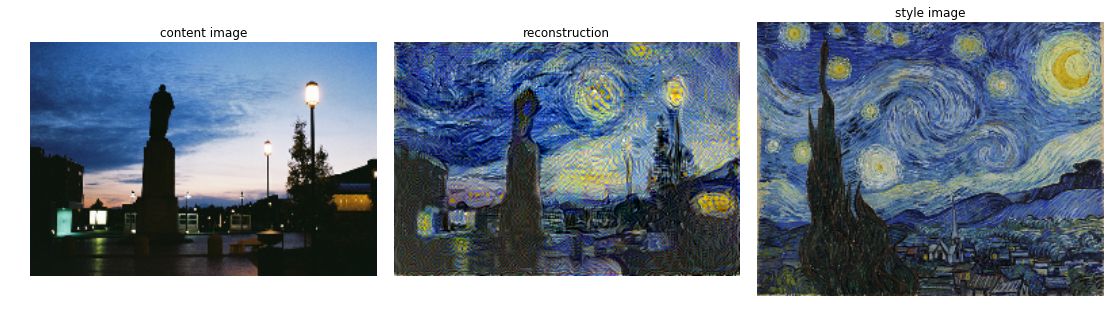

In [23]:
# generate reconstructed image
recon = res.x
recon = recon.reshape(net.blobs['data'].data[0].shape)
recon = transformer.deprocess('data', recon)

plt.rcParams["figure.figsize"] = [15.0, 15.0*2/3]

sub1 = plt.subplot(131)
sub1.set_title('content image')
sub1.imshow(content)
sub1.axis('off')

sub2 = plt.subplot(132)
sub2.set_title('reconstruction')
sub2.imshow(recon)
sub2.axis('off')

sub3 = plt.subplot(133)
sub3.set_title('style image')
sub3.imshow(style)
sub3.axis('off')

plt.tight_layout(pad=-1)
plt.show()

In [25]:
imsave('/home/haocabbage/Desktop/imgStyle/reconstruction.png', recon)